In [1]:
# Notebook to prototype iteratively aligning the points by finding correspondences and
# and transforming the paths
from __future__ import division
from os.path import join
import cPickle as pickle
import random

with open("../dataset_loc", 'r') as f:
    dataset_loc = f.read().rstrip()

with open(join(dataset_loc, "Flukes/zooniverse_curvatures_winteg.pkl"), 'r') as f:
    curvatures = pickle.load(f)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def visualize_paths(path1, path2):
    p1 = np.array(path1)
    p2 = np.array(path2)
    y_extent = max(np.max(np.abs(p1[:,1])), np.max(np.abs(p2[:,1])))
    # assume x_extent is 960
    image = np.ones((y_extent*2, 960, 3), dtype=np.uint8) * 255
    image[y_extent,:,:] = 0
    for point in p1:
        image[(y_extent-1) - point[1],point[0],:] = np.array([255,0,0])
    for point in p2:
        image[(y_extent-1) - point[1],point[0],:] = np.array([0,255,0])
    plt.figure(figsize=(15,15))
    plt.imshow(image[::-1,:,:])
    
    

In [3]:
from itertools import product
eqpairs = []
uneqpairs = []
for c1, c2 in product(curvatures, curvatures):
    if (c1['id'] == c2['id']) and (c1['fn'] != c2['fn']):
        eqpairs.append((c1, c2))
    elif (c1['id'] != c2['id']):
        uneqpairs.append((c1, c2))

12037
12037


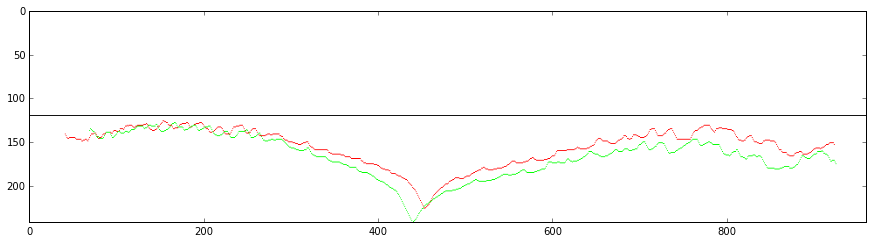

In [4]:
c1, c2 = random.choice(eqpairs)
print(c1['id'])
print(c2['id'])
visualize_paths(c1['path'], c2['path'])

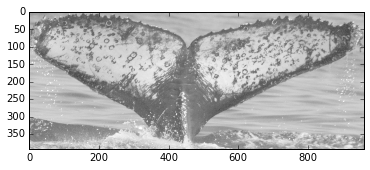

In [5]:
import cv2
imgs_dir = join(dataset_loc, 'Flukes/CRC_combined constrained')
plt.imshow(cv2.imread(join(imgs_dir, c1['fn'])))

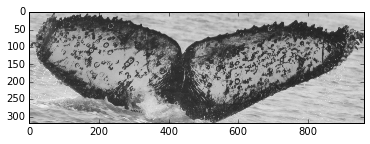

In [6]:
plt.imshow(cv2.imread(join(imgs_dir, c2['fn'])))

/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


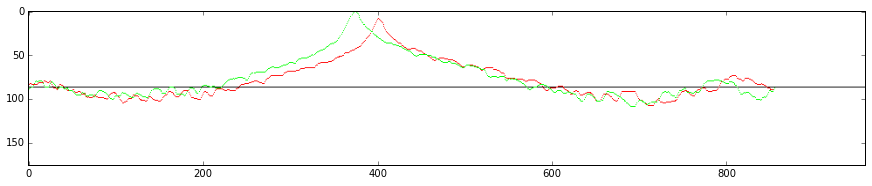

In [7]:
# So we want to do the following: given two paths, figure out an initial alignment
# find the line between the two end points, and rotate both lines so that the 
# slope of the line between the two end points is 0
# then we can translate both so that they lie on the x-axis
# then we can translate both so that the start point is at 0,0
# this is the initial alignment to the canonical coordinate system

def rotate_path(path, theta):
    #rotation_mat = np.hstack([
    rotation_mat = np.array(
                      [[np.cos(theta), -1*np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]])
            #translation.reshape(2,1)])
    #print(rotation_mat)
    #augmented_path = np.vstack([path.T, np.ones(path.shape[0])])
    augmented_path = path.T
    rotated_path = np.dot(rotation_mat, augmented_path).T[:,::-1]
    return rotated_path


def canonical_transform(p1, p2):
    p1 = np.array(p1)
    p2 = np.array(p2)
    offset1 = p1[-1]
    offset2 = p2[-1]
    
    p1_centered = p1 - offset1
    p2_centered = p2 - offset2
    #print(offset1)
    #print(offset2)
    
    rotation1 = np.arctan2(*(p1_centered[0]))
    rotation2 = np.arctan2(*(p2_centered[0]))
    #print(180*rotation1 / np.pi)
    #print(180*rotation2 / np.pi)
    p1_rotated = rotate_path(p1_centered, rotation1)
    p2_rotated = rotate_path(p2_centered, rotation2)
    
    # scale to the smaller one
    if p2_rotated[0,0] <= p1_rotated[0,0]:
        p1_rotated[:,0] *= (p2_rotated[0,0] / p1_rotated[0,0])
    else:
        p2_rotated[:,0] *= (p1_rotated[0,0] / p2_rotated[0,0])
        
    return p1_rotated, p2_rotated


visualize_paths(*canonical_transform(c1['path'], c2['path']))

(882, 2)
(856, 2)
6179.56


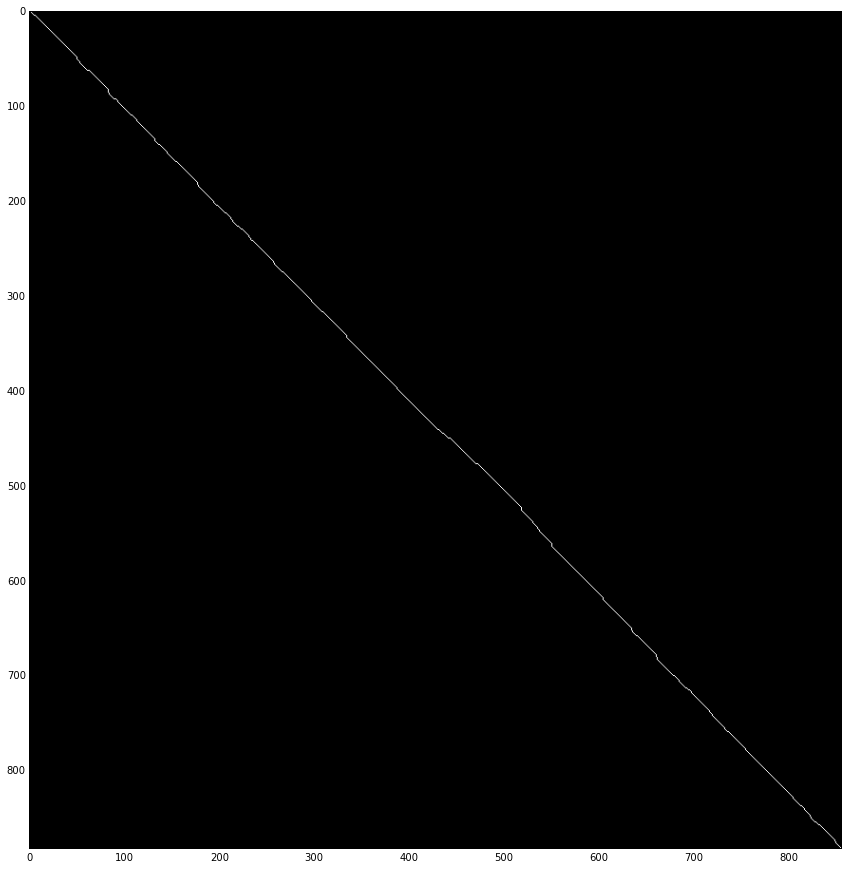

In [8]:
import ctypes
dtw_lib = ctypes.cdll.LoadLibrary('../edge_match/icp_ctypes_cpp/ctypes_icp.so')
dtw_dist = dtw_lib.dtw_windowed
dtw_scalar = dtw_lib.dtw_scalar

def get_dist_mat(aligned1, aligned2):
    seq1_len = aligned1.shape[0]
    seq2_len = aligned2.shape[0]
    
    seq1 = aligned1.astype(np.float32).flatten() + 1e-7
    seq2 = aligned2.astype(np.float32).flatten() + 1e-7
    
    distance_mat = (np.zeros((seq1_len, seq2_len), dtype=np.float32)) + np.inf
    #distance_mat[:,0] = np.inf
    #distance_mat[0,:] = np.inf
    distance_mat = distance_mat.flatten()
    distance_mat[0] = 0
    
    distance = dtw_dist(
                    #ctypes.c_void_p(seq1pos.ctypes.data), ctypes.c_void_p(seq2pos.ctypes.data),
                    ctypes.c_void_p(seq1.ctypes.data), ctypes.c_void_p(seq2.ctypes.data),
                    ctypes.c_int(seq1_len), ctypes.c_int(seq2_len), ctypes.c_int(100),
                    ctypes.c_void_p(distance_mat.ctypes.data))
    return distance_mat.reshape(seq1_len, seq2_len)

def get_neighbors(cell):
    candidate_neighbors = [(cell[0]-1, cell[1]-1),
                           (cell[0], cell[1]-1),
                           (cell[0]-1, cell[1])]
    return list(filter(lambda x: (x[0] >= 0) and
                                 (x[1] >= 0), candidate_neighbors))

def find_path(distance_mat):
    # find the optimal path from the last cell in the distance_mat to the first
    # todo: in the future it might just make sense to store the backtrace in another
    # matrix when the computation is being done
    curcell = (distance_mat.shape[0]-1, distance_mat.shape[1]-1)
    path = [curcell]
    path_info = [0]
    neighbors = get_neighbors(curcell)
    while (curcell != (0,0) and len(neighbors) > 0):
        next_neighbor_ind = np.argmin(distance_mat[zip(*neighbors)])
        if len(neighbors) != 3:
            neighbortype = 4
        else:
            neighbortype = next_neighbor_ind
        next_neighbor = neighbors[next_neighbor_ind]
        path.append(next_neighbor)
        path_info.append(neighbortype)
        curcell = next_neighbor
        neighbors = get_neighbors(curcell)
        #print(path)
        #break
    return path, path_info



p1_c, p2_c = canonical_transform(c1['path'], c2['path'])
print(p1_c.shape)
print(p2_c.shape)
distance_mat = get_dist_mat(p1_c, p2_c)
path, path_info = find_path(distance_mat)
#print(path)
view_path_mat = np.zeros(distance_mat.shape)
view_path_mat[zip(*path)] = 1
plt.figure(figsize=(15,15))
plt.gray()
plt.imshow(view_path_mat)
print(distance_mat[-1,-1])

In [9]:
def get_dist_mat_curv(query_curv, db_curv):
    sizes = query_curv.keys()
    avg_dist = 0
    distmats = []
    for size in sizes:
        Q1 = np.array(query_curv[size])
        Q2 = np.array(db_curv[size])
        seq1_len = Q1.shape[0]
        seq2_len = Q2.shape[0]

        seq1 = Q1.astype(np.float32).flatten() + 1e-7
        seq2 = Q2.astype(np.float32).flatten() + 1e-7

        distance_mat = (np.zeros((seq1_len, seq2_len), dtype=np.float32)) + np.inf
        #distance_mat[:,0] = np.inf
        #distance_mat[0,:] = np.inf
        distance_mat = distance_mat.flatten()
        distance_mat[0] = 0

        distance = dtw_scalar(
                        #ctypes.c_void_p(seq1pos.ctypes.data), ctypes.c_void_p(seq2pos.ctypes.data),
                        ctypes.c_void_p(seq1.ctypes.data), ctypes.c_void_p(seq2.ctypes.data),
                        ctypes.c_int(seq1_len), ctypes.c_int(seq2_len), ctypes.c_int(100),
                        ctypes.c_void_p(distance_mat.ctypes.data))

        #path, _ = find_path(distance_mat.reshape(seq1_len, seq2_len))
        distmats.append(distance_mat.reshape(seq1_len, seq2_len))
    avg_distmat = np.average(np.dstack(distmats), axis=2)
    return avg_distmat

In [10]:
import plottool as pt

[!plotttool] WARNING guitool does not have __PYQT__


/home/zach/envs/thesis/local/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


/home/zach/envs/thesis/local/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/zach/envs/thesis/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


37.412


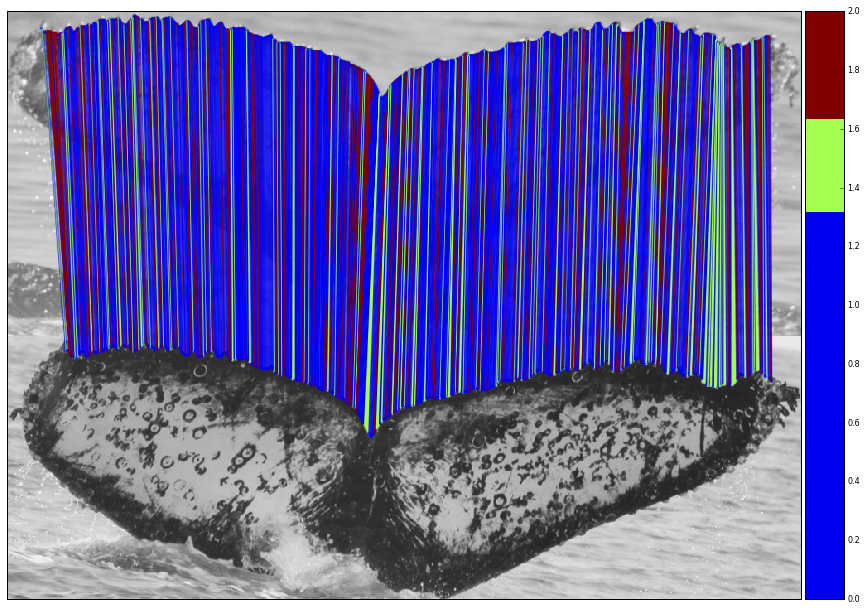

In [11]:

def draw_correspondences(c1, c2):
    # this will take the curvature items, open them
    # draw the compute paths on each image
    # then figure out the alignment between the paths (i.e. which index i into path 1
    # corresponds to some index j in path 2)
    img1 = cv2.imread(join(imgs_dir, c1['fn']))
    img2 = cv2.imread(join(imgs_dir, c2['fn']))
    p1_c, p2_c = canonical_transform(c1['path'], c2['path'])
    #distance_mat = get_dist_mat(p1_c, p2_c)
    distance_mat = get_dist_mat(np.array(c1['int_curv'][5]),
                                np.array(c2['int_curv'][5]))
    path, path_info = find_path(distance_mat)
    print(distance_mat[-1,-1])
    
    # kpts are : x, y, 1, 0, 1, 0
    # shape npoints x 6
    #print(p1_c.astype(np.int))
    invert_y = lambda x, extent: np.array([x[0], extent - x[1]])
    pts1 = np.array([c1['path'][p1_ind] for p1_ind, _ in path])
    pts2 = np.array([c2['path'][p2_ind] for _, p2_ind in path])
    acdtheta = np.zeros((len(path), 4))
    acdtheta[:,0] = 1
    acdtheta[:,2] = 1
    kpts1 = np.hstack([pts1, acdtheta])
    kpts2 = np.hstack([pts2, acdtheta])
    c1_comp = c1['int_curv'][5]
    c2_comp = c2['int_curv'][5]
    max_dist = np.max([np.linalg.norm(np.array(c1_comp[co1]) - np.array(c2_comp[co2])) 
                       for co1, co2 in path])
    dists = [1 - (np.linalg.norm(np.array(c1_comp[co1]) - 
                                 np.array(c2_comp[co2])) / max_dist)
                       for co1, co2 in path]
    #print(np.array(dists))
    pt.show_chipmatch2(img1, img2, kpts1, kpts2, 
                               fs=np.array(path_info),
                               cmap=plt.cm.jet,
                               line_alpha=dists,)
    fig = pt.gcf()
    fig.set_size_inches((15,15))
    """
    combined_img = np.vstack([img1, img2])
    max_dist = np.max([np.linalg.norm(np.array(p1_c[co1]) - np.array(p2_c[co2])) 
                       for co1, co2 in path])
    print(max_dist)
    for (c1_pos, c2_pos), corr_type in zip(path, path_info)[::10]:
        coords_1 = c1['path'][c1_pos]
        coords_2 = c2['path'][c2_pos]
        dist = np.linalg.norm(np.array(coords_1) - np.array(coords_2))
        percentage_of_max = dist / max_dist
        adjusted_coords_2 = (coords_2[0], coords_2[1] + img1.shape[0])
        color_tuple = [0,0,0]
        color_tuple[corr_type] = 255*percentage_of_max
        cv2.line(combined_img, coords_1, adjusted_coords_2, color=tuple(color_tuple))
    plt.figure(figsize=(15,15))
    plt.imshow(combined_img)
    """
draw_correspondences(c1, c2)

In [12]:

homog_aug = lambda x: np.hstack([x, np.ones((x.shape[0],1))])


def block_integral_curvatures(sizes, coords):
    # assume coords are in x, y
    fit_size = (np.max(coords, axis=0) - np.min(coords, axis=0)) + (max(sizes)+1)
    binarized = np.zeros(fit_size[::-1])
    fixed_coords = (coords - np.min(coords, axis=0)) + max(sizes) // 2
    binarized[zip(*fixed_coords)[::-1]] = 1
    binarized = binarized.cumsum(axis=0)
    binarized[np.where(binarized > 0)] = 1
    summed_table = binarized.cumsum(axis=0).cumsum(axis=1)
    #plt.figure(figsize=(15,15))
    #plt.imshow(binarized)
    #print(np.sum(binarized))
    curvs = {}
    for size in sizes:
        curvs[size] = []
        for j, i in coords:
            starti = max(0, i- (size // 2))
            startj = max(0, j- (size // 2))
            endi = min(binarized.shape[0]-1, i+ (size//2))
            endj = min(binarized.shape[1]-1, j+ (size//2))
            #this_summed_area = (summed_table[starti, startj] + summed_table[endi,endj] - 
            #                    (summed_table[starti,endj] + summed_table[endi,startj]))
            this_summed_area = np.average(binarized[starti:endi+1,startj:endj+1])
            if np.isnan(this_summed_area):
                this_summed_area = 0.
            #this_summed_area /= size**2
            curvs[size].append(this_summed_area)
    return curvs


def normalize_coords(coords):
    # subtract the mean coordinate
    mean_shifted = coords - np.average(coords, axis=0)
    magnitude_scaled = mean_shifted / (1e-7 + np.linalg.norm(mean_shifted, axis=1)).reshape(-1,1)
    return magnitude_scaled

def minimize_transform_homog(path, c1, c2):
    # figure out the A that minimizes norm(c1 - c2 . A)
    # assume path is a list of tuples as well

    c1 = np.hstack([c1, np.ones((c1.shape[0], 1))])
    c2 = np.hstack([c2, np.ones((c1.shape[0], 1))])
    
    transform = np.dot(np.linalg.inv(np.dot(c2.T, c2)),
                      np.dot(c2.T, c1))
    err = np.linalg.norm(c1 - np.dot(c2, transform))
    return transform, err

def minimize_transform_affine(path, c1, c2):
    c1 = np.hstack([c1, np.ones((c1.shape[0], 1))])
    #db_aug = np.hstack([db_aug, np.ones((db_aug.shape[0], 1))])
    
    transform = np.dot(np.linalg.inv(np.dot(c2.T, c2)),
                      np.dot(c2.T, c1))
    err = np.linalg.norm(c1 - np.dot(c2, transform))
    return transform, err

from cv2 import findHomography

def minimize_transform_ransac(path, c1, c2):
    transform, mask = findHomography(c2, c1, method=cv2.LMEDS, ransacReprojThreshold=0.01)
    if transform is None:
        raise ValueError("RANSAC said no transform for you")
    err = np.linalg.norm(homog_aug(c1) - np.dot(homog_aug(c2), transform))
    return transform, err, mask.reshape(-1).astype(np.bool)

def minimize_transform_median(path, c1, c2, mode='affine'):
    c1 = np.hstack([c1, np.ones((c1.shape[0], 1))])
    if mode == 'homog':
        c2 = np.hstack([c2, np.ones((c2.shape[0], 1))])
    
    init_transform = np.dot(np.linalg.inv(np.dot(c2.T, c2)),
                      np.dot(c2.T, c1))
    errs = np.linalg.norm(c1 - np.dot(c2, init_transform),axis=1)
    
    sigma = np.median(errs) * 1.5
    filtered_c1 = c1[np.where(errs < 2.5*sigma)]
    filtered_c2 = c2[np.where(errs < 2.5*sigma)]
    final_transform = np.dot(np.linalg.inv(np.dot(filtered_c2.T, filtered_c2)),
                             np.dot(filtered_c2.T, filtered_c1))
    final_err = np.linalg.norm(c1 - np.dot(c2, init_transform))
    return final_transform, final_err

    

query_aug = np.array([p1_c[co1] for co1, _ in path])
db_aug = np.array([p2_c[co2] for _, co2 in path])

print(minimize_transform_affine(path, query_aug, db_aug))
print(minimize_transform_homog(path, query_aug, db_aug))
#print(minimize_transform_ransac(path, query_aug, db_aug))
print(minimize_transform_median(path, query_aug, db_aug))


(array([[ 1.00120081, -0.00252285,  0.00164602],
       [-0.06969886,  0.83202834, -0.00675715]]), 246.0819542336088)
(array([[  1.00074655e+00,  -9.95993067e-03,  -8.67361738e-19],
       [ -6.78340588e-02,   8.62558548e-01,   6.93889390e-18],
       [  2.75973835e-01,   4.51820784e+00,   1.00000000e+00]]), 236.93210832278149)
(array([[ 1.00119975, -0.00234188,  0.00164513],
       [-0.06907826,  0.83669326, -0.0070956 ]]), 246.0819542336088)


In [13]:
import time

def transformed_dist(c1, c2, maxiter=10, tol=1e-3, verbose=False, startmat=None, transform_type='affine', 
                     normalize=False, usecurv=True, sizes=[5,10,15,20]):
    # alternate the affine solve and dtw
    # usecurv: use the curvature estimates for the dynamic time warping correspondences
    cur_err = np.inf
    err = 0
    itr = 0
    
    cur_query = np.array(c1,dtype=np.int)[:]
    if usecurv:
        query_curv = block_integral_curvatures(sizes, cur_query)
    cur_db = np.array(c2,dtype=np.int)[:]
    
    if normalize:
        cur_query = normalize_coords(cur_query)
        cur_db = normalize_coords(cur_db)
        
    cur_db_transformed = cur_db[:]
    errs = []
    dists = []
    transforms = []
    distmat_tocs = 0
    path_tocs = 0
    transform_tocs = 0
    mask = None

    while (itr < maxiter):
        distmat_tic = time.time()
        if startmat is None:
            if usecurv:
                db_curv = block_integral_curvatures(sizes, cur_db_transformed)
                #print(db_curv)
                dist_mat = get_dist_mat_curv(query_curv, db_curv)
            else:
                dist_mat = get_dist_mat(cur_query, cur_db_transformed)
        else:
            dist_mat = startmat[:]
            startmat = None
        distmat_toc = time.time() - distmat_tic
        distmat_tocs += distmat_toc
        #print(dist_mat.shape)
        if (abs(cur_err - err) < tol):# or (err > (cur_err + 1e-7)):
            # reached convergence
            break
        cur_err = err
        path_tic = time.time()
        #print(dist_mat.shape)
        path, path_info = find_path(dist_mat)
        #print(path)
        path_toc = time.time() - path_tic
        path_tocs += path_toc
        query_pts = np.array([cur_query[co1] for co1, _ in path])
        db_pts = np.array([cur_db[co2] for _, co2 in path])
        transform_tic = time.time()
        if transform_type == 'affine':
            best_transform, err = minimize_transform_median(path, query_pts, db_pts, mode='affine')
            cur_db_aug = np.dot(cur_db, best_transform).astype(np.int)
        else:
            try:
                best_transform, err = minimize_transform_median(path, query_pts, db_pts, mode='homog')
            except ValueError as vae:
                if verbose:
                    print(vae)
                break
            cur_db_aug = np.dot(homog_aug(cur_db), best_transform)
        transform_toc = time.time() - transform_tic
        transform_tocs += transform_toc
        cur_db_transformed = cur_db_aug[:,:2]
        itr += 1
        errs.append(err)
        #plt.imshow(dist_mat)
        dists.append(dist_mat[-1,-1])
        transforms.append(best_transform)
    if verbose:
        print("Distmat took %0.5fs on avg\n"
              "Path took %0.5fs on avg\n"
              "Transform took %0.5fs on avg\n" %
              (distmat_tocs / itr, path_tocs / itr, transform_tocs / itr))
        print("Took %d iterations" % itr)
    return dist_mat, errs, dists, transforms

def aidtw(c1, c2, compare_on='path', startmat=None, transform='affine'):
    if compare_on == 'path':
        pts1, pts2 = canonical_transform(c1[compare_on], c2[compare_on])
    else:
        pts1 = c1[compare_on]
        pts2 = c2[compare_on]
    _, _, dists, _ = transformed_dist(pts1, pts2, startmat=startmat, 
                                      transform_type=transform)
    return dists[-1]

def aidtw_curv(c1, c2, transform='affine', compare_on='path'):
    _, _, dists, _ = transformed_dist(c1['path'], c2['path'], transform_type='affine', usecurv=True)
    return dists[-1]

initial_distmat = get_dist_mat(np.array(c1['int_curv'][5]),
                               np.array(c2['int_curv'][5]))
_, errs, dists, transforms = transformed_dist(p1_c, p2_c, maxiter=10, 
                                              startmat=None, transform_type='homog',
                                             verbose=True, usecurv=True, sizes=[15])


/home/zach/envs/thesis/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/zach/envs/thesis/local/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Distmat took 0.04617s on avg
Path took 0.01192s on avg
Transform took 0.00057s on avg

Took 10 iterations


/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:27: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


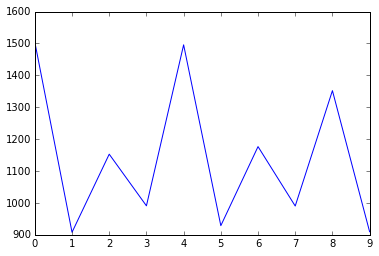

In [46]:
plt.plot(range(len(errs)), errs)

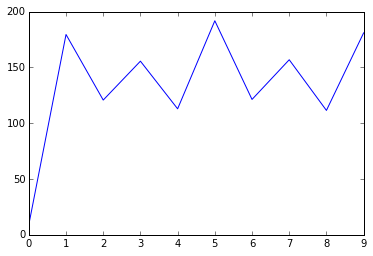

In [47]:
plt.plot(range(len(dists)), dists)

In [48]:
dists

[9.1670322,
 179.48727,
 120.73305,
 155.58728,
 112.89513,
 191.77716,
 121.29624,
 156.85487,
 111.45901,
 180.91719]

/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


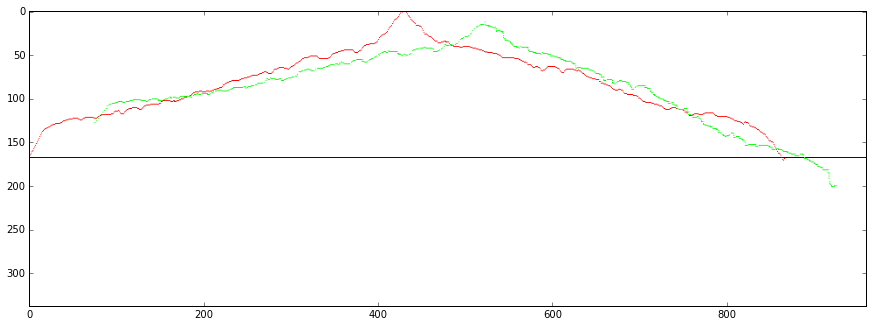

In [49]:
visualize_paths(p1_c, np.dot(homog_aug(p2_c), transforms[-1])[:,:2])

In [37]:
transforms[-1]

array([[  9.74419505e-01,  -2.43781491e-02,   8.89551727e-04],
       [ -3.13370189e-02,   1.22720362e+00,  -8.26220450e-03]])

In [394]:
#TODO Move this out of this notebook
import random
import utool as ut
def triplet_eval(curvatures, dist_method, compare_on, n_triplets=200):
    # generate triplets
    # the idea of a triplet is that we have an anchor sample and two other samples
    # one with the same id as the anchor and the other with a different id
    # (a1, a2, b) and we count a 0 if dist(a1,a2) < dist(a1,b) 
    # this way we can evaluate a distance method using 2*n_triplets comparisons,
    # which is significantly faster
    id_curv_map = {}
    for curv in curvatures:
        if curv['id'] in id_curv_map:
            id_curv_map[curv['id']].append(curv)
        else:
            id_curv_map[curv['id']] = [curv]
    #print(len(id_curv_map))
    good_count = 0
    # for complete coverage we'll generate a triplet for at most each id
    idlist = filter(lambda x: len(id_curv_map[x]) > 1, id_curv_map.keys())
    for _ in range(n_triplets):
        anchor = random.choice(idlist)
        random.shuffle(id_curv_map[anchor])
        negative = random.choice(filter(lambda x: x != anchor, idlist))
        random.shuffle(id_curv_map[negative])
        anchor_pos_dist = dist_method(id_curv_map[anchor][0], id_curv_map[anchor][1],
                                     compare_on=compare_on)
        anchor_neg_dist = dist_method(id_curv_map[anchor][0], id_curv_map[negative][0],
                                     compare_on=compare_on)
        if anchor_pos_dist < anchor_neg_dist:
            good_count += 1
            
    return good_count / float(n_triplets)

triplet_eval(curvatures, aidtw_curv, 'path', n_triplets=200)

IndexError: index 915 is out of bounds for axis 1 with size 889

In [16]:
def cpp_dtw_dist(c1, c2, compare_on='path'):
    # HACK
    if compare_on == 'int_curv':
        c1 = c1[compare_on]
        c2 = c2[compare_on]
        compare_on = 5
    c1 = np.array(c1[compare_on])
    c2 = np.array(c2[compare_on])
    distmat = get_dist_mat(c1, c2)
    return distmat[-1,-1]

def int_curv_dist(c1, c2):
    curv1 = np.array(c1[5])
    curv2 = np.array(c2[5])
    distmat = get_dist_mat(curv1, curv2)
    return distmat[-1,-1]

triplet_eval(curvatures, cpp_dtw_dist, 'int_curv', n_triplets=1000)

0.795

In [17]:
def aidtw_curvinit(c1, c2, compare_on='path'):
    initial_distmat = get_dist_mat(np.array(c1['int_curv'][5]),
                                   np.array(c2['int_curv'][5]))
    return aidtw(c1, c2, compare_on=compare_on, startmat=initial_distmat)

In [18]:
triplet_eval(curvatures, aidtw_curvinit, 'path', n_triplets=1000)

0.712

In [19]:
initial_distmat = get_dist_mat(np.array(c1['int_curv'][5]),
                                   np.array(c2['int_curv'][5]))
_, errs, dists, transforms = transformed_dist(c1['path'], c2['path'], startmat=initial_distmat)

/home/zach/envs/thesis/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


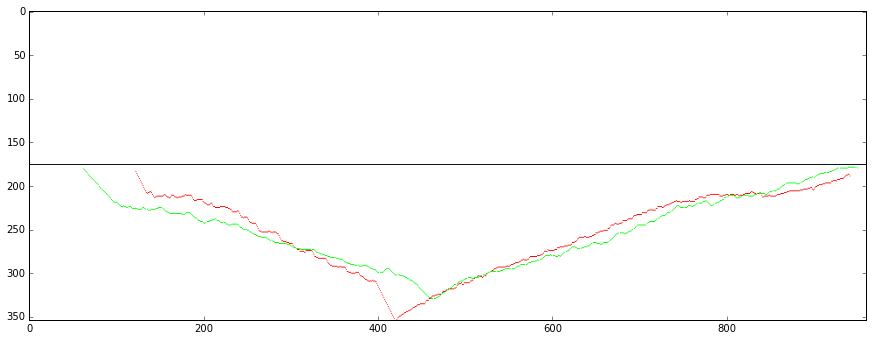

In [20]:
visualize_paths(np.array(c1['path']), 
                         np.dot(c2['path'], transforms[-1]))

In [21]:
transforms[-1]

array([[  1.05464010e+00,  -7.71566905e-04,   9.91983559e-04],
       [ -2.22423444e-02,   5.36316982e-01,   3.08098989e-03]])

In [39]:
def rank_eval(curvatures, dist_method=cpp_dtw_dist, compare_on='diffhist', k=5, verbose=0, sample_size=None):
    found_ins = [0]*(k+1)
    tic = time.time()
    hist = {}
    for c in curvatures:
        if c['id'] not in hist:
            hist[c['id']] = 1
        else:
            hist[c['id']] += 1
    bad_ids = set(filter(lambda x: hist[x] == 1, hist.keys()))
    random.shuffle(curvatures)
    if sample_size is None:
        upto = len(curvatures)
    else:
        upto = sample_size
    for qimg in ut.ProgressIter(range(upto), lbl='QueryImage', enabled=(verbose > 0)):
        if curvatures[qimg]['id'] in bad_ids:
            continue
        db = [c for ind, c in enumerate(curvatures) if ind != qimg]
        #db = curvatures
        dists = {}
        eval_tic = time.time()
        for db_c in ut.ProgressIter(db, lbl='dist', enabled=(verbose > 1)):
            single_tic = time.time()
            distance = dist_method(curvatures[qimg], db_c, compare_on=compare_on)
            if db_c['id'] not in dists:
                dists[db_c['id']] = [distance]
            else:
                dists[db_c['id']].append(distance)
            single_toc = time.time() - single_tic
            #if verbose > 1:
            #    print(single_toc)
        dists = {crcid:np.average(dists[crcid]) for crcid in dists}
        #print(dists[curvatures[qimg]['id']])
        top_k = sorted(dists.keys(),key=lambda x: dists[x])[:k]
        try:
            found_k = top_k.index(curvatures[qimg]['id'])
        except ValueError:
            found_k = -1
        if verbose > 0:
            print("Average distance for correct id: %0.2f, giving k=%d" % (dists[curvatures[qimg]['id']],
                                                                           found_k))
            print("Distance for k=0: %0.2f" % dists[top_k[0]])
        found_ins[found_k] += 1
        eval_toc = time.time() - eval_tic
        #if verbose > 0:
        #    print("Took %0.2f seconds to evaluate image %d" % (eval_toc, qimg))
    toc = time.time() - tic
    print("Took %0.2f seconds" % toc)
    found_ins = [f_in / upto for f_in in found_ins]
    return found_ins

In [ ]:
aidtw_eval = rank_eval(curvatures, dist_method=aidtw, compare_on='path', verbose=1, sample_size=100)

QueryImage    0/100...  Average distance for correct id: 8164.41, giving k=-1
Distance for k=0: 2484.93
QueryImage    1/100...  rate=0.01 Hz, etr: 3:58:19, ellapsed: 0:02:24, wall: 16:38 EST
Average distance for correct id: 2448.60, giving k=0
Distance for k=0: 2448.60
QueryImage    2/100...  rate=0.01 Hz, etr: 3:58:54, ellapsed: 0:04:50, wall: 16:40 EST
Average distance for correct id: 10481.25, giving k=-1
Distance for k=0: 5097.86
QueryImage    3/100...  rate=0.01 Hz, etr: 3:55:01, ellapsed: 0:07:16, wall: 16:43 EST
Average distance for correct id: 10532.33, giving k=-1
Distance for k=0: 2760.79
QueryImage    4/100...  rate=0.01 Hz, etr: 3:43:04, ellapsed: 0:09:35, wall: 16:45 EST
Average distance for correct id: 11347.73, giving k=-1
Distance for k=0: 5430.70
QueryImage    5/100...  rate=0.01 Hz, etr: 3:43:10, ellapsed: 0:11:56, wall: 16:47 EST
Average distance for correct id: 4647.05, giving k=-1
Distance for k=0: 3417.72
QueryImage    6/100...  rate=0.01 Hz, etr: 3:50:02, ellapse

In [342]:
print(aidtw_eval)


[0.13, 0.01, 0.04, 0.01, 0.0, 0.8]


In [ ]:
aidtw_ci_eval = rank_eval(curvatures, dist_method=aidtw_curvinit, compare_on='path', verbose=1, sample_size=50)

In [46]:
print(aidtw_ci_eval)

[0.22, 0.06, 0.02, 0.0, 0.04, 0.66]


In [63]:
from functools import partial

def homog_aidtw(c1, c2, compare_on='path'):
    return aidtw(c1, c2, compare_on=compare_on, startmat=None, transform='homog')

def homog_aidtw_curvinit(c1, c2, compare_on='path'):
    initial_distmat = get_dist_mat(np.array(c1['int_curv'][5]),
                                   np.array(c2['int_curv'][5]))
    return aidtw(c1, c2, compare_on=compare_on, startmat=initial_distmat, transform='homog')

In [64]:
from inspect import getargspec
getargspec(aidtw)

ArgSpec(args=['c1', 'c2', 'compare_on', 'startmat', 'transform'], varargs=None, keywords=None, defaults=('path', None, 'affine'))

In [67]:
homog_aidtw_eval = rank_eval(curvatures, dist_method=homog_aidtw, compare_on='path', verbose=1, sample_size=100)

QueryImage    0/100...  Average distance for correct id: 6487.66, giving k=-1
Distance for k=0: 2319.01
QueryImage    1/100...  rate=0.01 Hz, etr: 3:58:14, ellapsed: 0:02:24, wall: 16:37 EST
Average distance for correct id: 3380.09, giving k=-1
Distance for k=0: 2529.40
QueryImage    2/100...  rate=0.01 Hz, etr: 3:53:51, ellapsed: 0:04:47, wall: 16:39 EST
Average distance for correct id: 4261.79, giving k=-1
Distance for k=0: 2509.15
QueryImage    3/100...  rate=0.01 Hz, etr: 3:50:51, ellapsed: 0:07:10, wall: 16:42 EST
Average distance for correct id: 2731.64, giving k=-1
Distance for k=0: 2102.61
QueryImage    4/100...  rate=0.01 Hz, etr: 3:57:55, ellapsed: 0:09:39, wall: 16:44 EST
Average distance for correct id: 3146.29, giving k=1
Distance for k=0: 3102.18
QueryImage    5/100...  rate=0.01 Hz, etr: 3:51:10, ellapsed: 0:12:05, wall: 16:47 EST
Average distance for correct id: 3394.93, giving k=-1
Distance for k=0: 2258.36
QueryImage    6/100...  rate=0.01 Hz, etr: 3:42:47, ellapsed: 

In [ ]:
print(homog_aidtw_eval)

[0.22, 0.05, 0.05, 0.02, 0.01, 0.65]


In [ ]:
homog_aidtw_ci_eval = rank_eval(curvatures, dist_method=homog_aidtw_curvinit, 
                             compare_on='path', verbose=1)

QueryImage    0/816...  Average distance for correct id: 16298.00, giving k=-1
Distance for k=0: 14897.19
QueryImage    1/816...  rate=0.01 Hz, etr: 1 day, 9:52:26, ellapsed: 0:02:29, wall: 11:14 EST
Average distance for correct id: 3329.23, giving k=-1
Distance for k=0: 2618.74
QueryImage    2/816...  rate=0.01 Hz, etr: 1 day, 9:14:27, ellapsed: 0:04:56, wall: 11:17 EST
Average distance for correct id: 4045.11, giving k=0
Distance for k=0: 4045.11
QueryImage    3/816...  rate=0.01 Hz, etr: 1 day, 9:22:32, ellapsed: 0:07:24, wall: 11:19 EST
Average distance for correct id: 1757.32, giving k=0
Distance for k=0: 1757.32
QueryImage    4/816...  rate=0.01 Hz, etr: 1 day, 9:01:25, ellapsed: 0:09:50, wall: 11:21 EST
Average distance for correct id: 2043.22, giving k=0
Distance for k=0: 2043.22
QueryImage    5/816...  rate=0.01 Hz, etr: 1 day, 9:44:51, ellapsed: 0:12:20, wall: 11:24 EST
Average distance for correct id: 4452.70, giving k=-1
Distance for k=0: 3626.29
QueryImage    6/816...  rat

In [73]:
print(homog_aidtw_ci_eval)

[0.39828431372549017, 0.06372549019607843, 0.03431372549019608, 0.028186274509803922, 0.014705882352941176, 0.45588235294117646]
